In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os

In [3]:
print(os.listdir("/gdrive/My Drive/Goz_Hastaliklari/Cataract-Normal"))

['Cataract', 'Normal']


In [4]:
DATADIR = "/gdrive/My Drive/Goz_Hastaliklari/Cataract-Normal"

CATEGORIES = ["Cataract","Normal"]

In [5]:
IMG_SIZE = 50

In [6]:
all_data = []

def create_all_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                all_data.append([new_array, class_num])
            except Exception as e:
                pass

create_all_data()


In [7]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  2113


In [8]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [11]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1235, 50, 50, 3)
(740, 50, 50, 3)
(138, 50, 50, 3)
(1235,)
(740,)
(138,)


In [12]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [13]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [14]:
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [15]:
res = tf.keras.applications.ResNet50V2(
    input_shape=(50, 50, 3),
    include_top = False
)

94668760/94668760 [==============================] - 1s 0us/step


In [16]:
res_model = Sequential()
res_model.add(res)
res_model.add(Dropout(0.25))
res_model.add(MaxPooling2D())
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(2, activation='softmax'))

In [17]:
res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = res_model.fit(x_train, train_yCl,
                        batch_size=120,
                        epochs=10,
                        validation_data=(x_val, valid_yCl))

Epoch 1/10
11/11 [==============================] - 43s 567ms/step - loss: 0.6418 - accuracy: 0.7684 - val_loss: 46.0344 - val_accuracy: 0.5362
Epoch 2/10
11/11 [==============================] - 1s 108ms/step - loss: 0.2662 - accuracy: 0.9028 - val_loss: 332.5359 - val_accuracy: 0.4710
Epoch 3/10
11/11 [==============================] - 1s 106ms/step - loss: 0.2271 - accuracy: 0.9101 - val_loss: 675.3998 - val_accuracy: 0.4710
Epoch 4/10
11/11 [==============================] - 1s 99ms/step - loss: 0.1319 - accuracy: 0.9498 - val_loss: 310.5477 - val_accuracy: 0.4710
Epoch 5/10
11/11 [==============================] - 1s 105ms/step - loss: 0.1118 - accuracy: 0.9555 - val_loss: 137.6512 - val_accuracy: 0.4783
Epoch 6/10
11/11 [==============================] - 1s 107ms/step - loss: 0.0835 - accuracy: 0.9733 - val_loss: 9.2490 - val_accuracy: 0.7754
Epoch 7/10
11/11 [==============================] - 1s 104ms/step - loss: 0.0703 - accuracy: 0.9725 - val_loss: 10.8793 - val_accuracy: 0.8

In [19]:
score_valid = res_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = res_model.evaluate(x_test, test_yCl)
print("Test Accuracy: ", score_test[1])

score_train = res_model.evaluate(x_train, train_yCl)
print("Train Accuracy: ", score_train[1])

5/5 [==============================] - 2s 223ms/step - loss: 4.0956 - accuracy: 0.7536
Validation Accuracy:  0.7536231875419617
24/24 [==============================] - 1s 45ms/step - loss: 3.7648 - accuracy: 0.8054
Test Accuracy:  0.8054053783416748
39/39 [==============================] - 2s 40ms/step - loss: 3.2367 - accuracy: 0.8146
Train Accuracy:  0.8145748972892761


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Test verisi üzerinde tahminlerde bulunun
y_pred_probs = res_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Gerçek sınıfları alın
y_true_classes = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1-Score: {f1}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)


24/24 [==============================] - 1s 16ms/step
Accuracy: 0.8054054054054054
Precision: 0.8380955981132655
Recall: 0.8054054054054054
F1-Score: 0.8000563999164775
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.64      0.77       365
           1       0.74      0.96      0.83       375

    accuracy                           0.81       740
   macro avg       0.84      0.80      0.80       740
weighted avg       0.84      0.81      0.80       740

Confusion Matrix:
[[235 130]
 [ 14 361]]


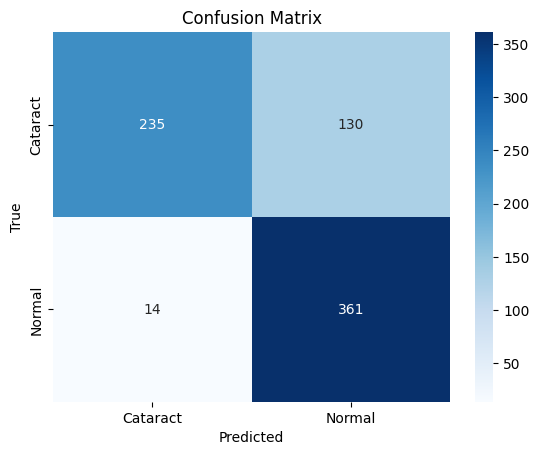

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [23]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [24]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1521, 50, 50, 3)
(423, 50, 50, 3)
(169, 50, 50, 3)
(1521,)
(423,)
(169,)


In [25]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [26]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [27]:
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [28]:
res = tf.keras.applications.ResNet50V2(
    input_shape=(50, 50, 3),
    include_top = False
)

In [29]:
res_model = Sequential()
res_model.add(res)
res_model.add(Dropout(0.25))
res_model.add(MaxPooling2D())
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(2, activation='softmax'))

In [30]:
res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
history = res_model.fit(x_train, train_yCl,
                        batch_size=120,
                        epochs=10,
                        validation_data=(x_val, valid_yCl))

Epoch 1/10
13/13 [==============================] - 33s 415ms/step - loss: 0.5846 - accuracy: 0.7679 - val_loss: 9.3679 - val_accuracy: 0.6568
Epoch 2/10
13/13 [==============================] - 1s 106ms/step - loss: 0.3339 - accuracy: 0.8922 - val_loss: 25.8879 - val_accuracy: 0.5030
Epoch 3/10
13/13 [==============================] - 1s 108ms/step - loss: 0.2317 - accuracy: 0.9034 - val_loss: 23.5834 - val_accuracy: 0.4970
Epoch 4/10
13/13 [==============================] - 1s 106ms/step - loss: 0.1802 - accuracy: 0.9277 - val_loss: 3.3148 - val_accuracy: 0.8047
Epoch 5/10
13/13 [==============================] - 1s 105ms/step - loss: 0.1129 - accuracy: 0.9467 - val_loss: 3.3642 - val_accuracy: 0.8166
Epoch 6/10
13/13 [==============================] - 1s 106ms/step - loss: 0.0851 - accuracy: 0.9698 - val_loss: 5.0952 - val_accuracy: 0.7456
Epoch 7/10
13/13 [==============================] - 1s 109ms/step - loss: 0.0740 - accuracy: 0.9730 - val_loss: 2.0499 - val_accuracy: 0.7870
Epo

In [32]:
score_valid = res_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = res_model.evaluate(x_test, test_yCl)
print("Test Accuracy: ", score_test[1])

score_train = res_model.evaluate(x_train, train_yCl)
print("Train Accuracy: ", score_train[1])

6/6 [==============================] - 2s 298ms/step - loss: 1.6165 - accuracy: 0.8757
Validation Accuracy:  0.8757396340370178
14/14 [==============================] - 1s 73ms/step - loss: 1.9127 - accuracy: 0.8558
Test Accuracy:  0.8557919859886169
48/48 [==============================] - 1s 31ms/step - loss: 1.1560 - accuracy: 0.8981
Train Accuracy:  0.8980933427810669


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Test verisi üzerinde tahminlerde bulunun
y_pred_probs = res_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Gerçek sınıfları alın
y_true_classes = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1-Score: {f1}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)


14/14 [==============================] - 1s 18ms/step
Accuracy: 0.8557919621749409
Precision: 0.8699488623178464
Recall: 0.8557919621749409
F1-Score: 0.85352202160254
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       201
           1       0.80      0.96      0.87       222

    accuracy                           0.86       423
   macro avg       0.87      0.85      0.85       423
weighted avg       0.87      0.86      0.85       423

Confusion Matrix:
[[149  52]
 [  9 213]]


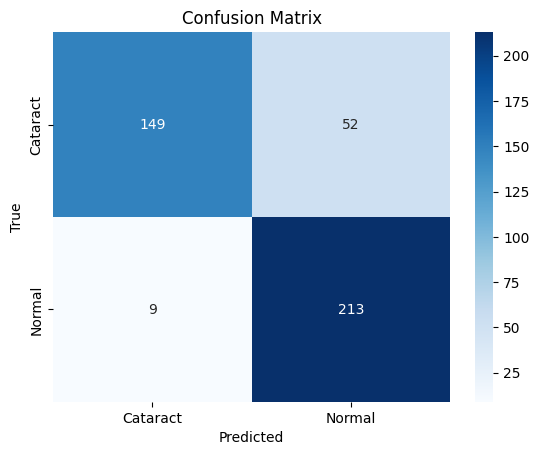

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
